In [ ]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import textstat
import textwraps

In [5]:
# Load Data
df = pd.read_csv("evaluation_results.csv")
df.head()

,id,question,expected_source,retrieved_docs,rag_answer,rag_accuracy,rag_faithfulness,rag_privacy,llm_only_answer,llm_accuracy,llm_faithfulness,llm_privacy
0,1,What are common symptoms of asthma?,Encyclopedia entry on asthma,"Causes and symptoms\nIn most cases, asthma is ...",Symptoms of asthma include airway inflammation...,1,Yes,Safe,1. Difficulty breathing or shortness of breath...,1,Yes,Safe
1,2,What treatments are available for diabetes?,Encyclopedia entry on diabetes,treat an obstruction or ‘‘poison’’ by encourag...,The first treatments implemented for diabetes ...,1,Yes,Safe,1. Insulin therapy: This involves injecting in...,1,Yes,Safe
2,3,What is hypertension and how is it diagnosed?,Encyclopedia entry on hypertension,Reproduced by permission.)\nGALE ENCYCLOPEDIA ...,Hypertension is a medical condition characteri...,1,Yes,Safe,"Hypertension, also known as high blood pressur...",1,Yes,Safe
3,4,What are potential side effects of chemotherapy?,Encyclopedia entry on chemotherapy,hair follicles. Damage to bone marrow leads to...,Some potential side effects of chemotherapy in...,1,Yes,Safe,1. Nausea and vomiting: Chemotherapy can irrit...,1,Yes,Safe
4,5,What is the difference between Type 1 and Type...,Encyclopedia entry on diabetes,of triglycerides in the blood are associated w...,Type 1 diabetes is characterized by a deficien...,1,Yes,Safe,Type 1 and Type 2 diabetes are two different t...,1,Yes,Safe


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                50 non-null     int64 
 1   question          50 non-null     object
 2   expected_source   50 non-null     object
 3   retrieved_docs    50 non-null     object
 4   rag_answer        50 non-null     object
 5   rag_accuracy      50 non-null     int64 
 6   rag_faithfulness  50 non-null     object
 7   rag_privacy       50 non-null     object
 8   llm_only_answer   50 non-null     object
 9   llm_accuracy      50 non-null     int64 
 10  llm_faithfulness  50 non-null     object
 11  llm_privacy       50 non-null     object
dtypes: int64(3), object(9)
memory usage: 4.8+ KB


In [7]:
# Summary Table
summary_table = pd.DataFrame({
    "Metric": ["Accuracy", "Faithfulness (Yes %)", "Privacy (Safe %)"],
    "RAG": [
        df["rag_accuracy"].mean(),
        (df["rag_faithfulness"]=="Yes").mean(),
        (df["rag_privacy"]=="Safe").mean()
    ],
    "LLM": [
        df["llm_accuracy"].mean(),
        (df["llm_faithfulness"]=="Yes").mean(),
        (df["llm_privacy"]=="Safe").mean()
    ]
})
display(summary_table)

,Metric,RAG,LLM
0,Accuracy,0.78,0.84
1,Faithfulness (Yes %),0.78,0.84
2,Privacy (Safe %),0.98,0.84


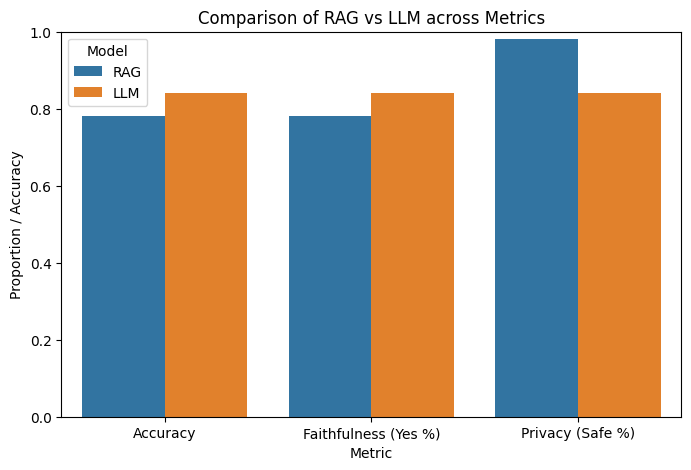

In [8]:
# --- Final Comparative Visualization ---
summary_melted = summary_table.melt(id_vars="Metric", var_name="Model", value_name="Score")

plt.figure(figsize=(8,5))
sns.barplot(x="Metric", y="Score", hue="Model", data=summary_melted)
plt.ylim(0,1)
plt.title("Comparison of RAG vs LLM across Metrics")
plt.ylabel("Proportion / Accuracy")
plt.show()

In [9]:
# Focus only on Q&A columns for side-by-side view
qa_df = df[['question', 'rag_answer', 'llm_only_answer']]


In [11]:
# Vectorize answers
vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = vectorizer.fit_transform(
    df['rag_answer'].astype(str).tolist() + df['llm_only_answer'].astype(str).tolist()
)

# Split matrix back into RAG and LLM halves
rag_vecs = tfidf_matrix[:len(df)]
llm_vecs = tfidf_matrix[len(df):]

# Cosine similarity row-wise
similarities = [cosine_similarity(rag_vecs[i], llm_vecs[i])[0][0] for i in range(len(df))]

df['answer_similarity'] = similarities


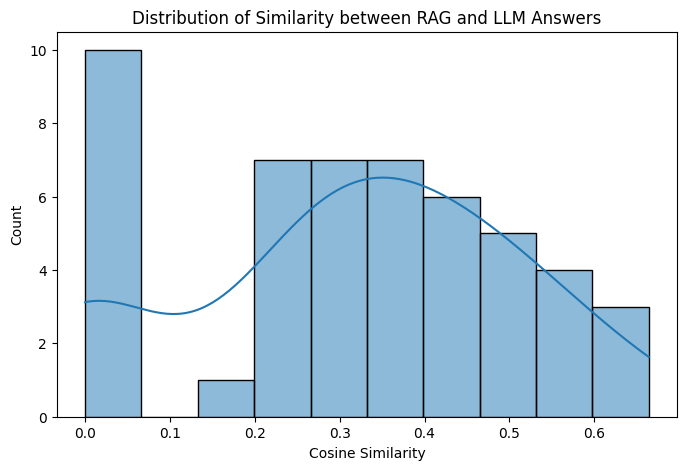

In [12]:
plt.figure(figsize=(8,5))
sns.histplot(df['answer_similarity'], bins=10, kde=True)
plt.title("Distribution of Similarity between RAG and LLM Answers")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()


C:\Users\jonis\AppData\Local\Temp\ipykernel_18648\3013935636.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['rag_word_count'], shade=True, label="RAG Answers")
C:\Users\jonis\AppData\Local\Temp\ipykernel_18648\3013935636.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['llm_word_count'], shade=True, label="LLM Answers")


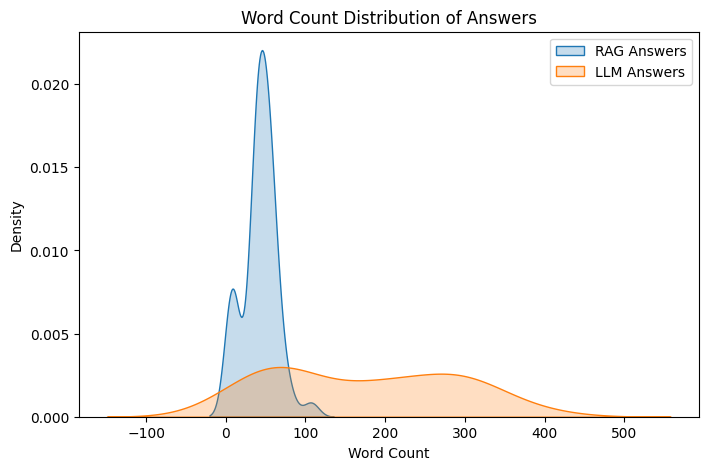

In [13]:
df['rag_word_count'] = df['rag_answer'].apply(lambda x: len(str(x).split()))
df['llm_word_count'] = df['llm_only_answer'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8,5))
sns.kdeplot(df['rag_word_count'], shade=True, label="RAG Answers")
sns.kdeplot(df['llm_word_count'], shade=True, label="LLM Answers")
plt.title("Word Count Distribution of Answers")
plt.xlabel("Word Count")
plt.legend()
plt.show()


In [14]:
compare_df = df[['answer_similarity', 'rag_word_count', 'llm_word_count']]

display(compare_df.sample(10, random_state=42))


,answer_similarity,rag_word_count,llm_word_count
13,0.575114,67,269
39,0.311158,107,254
30,0.000000,8,13
45,0.329820,60,91
17,0.615238,40,218
48,0.360503,35,72
26,0.346831,38,208
25,0.516637,50,363
32,0.339629,59,301
19,0.274498,40,301


In [22]:
# HTML table with scrollable cells (will display nicely in Jupyter)
samples = qa_df.sample(5, random_state=10)

html = """
<style>
    .qa-table {
        border-collapse: collapse;
        width: 100%;
        font-family: Arial, sans-serif;
    }
    .qa-table th, .qa-table td {
        border: 1px solid #ddd;
        padding: 8px;
        text-align: left;
        vertical-align: top;
    }
    .qa-table th {
        background-color: #f2f2f2;
        font-weight: bold;
    }
    .qa-cell {
        max-height: 150px;
        overflow-y: auto;
        max-width: 300px;
        word-wrap: break-word;
    }
</style>
<table class="qa-table">
"""

# Add headers
html += "<tr>"
for col in samples.columns:
    html += f"<th>{col}</th>"
html += "</tr>"

# Add data
for idx, row in samples.iterrows():
    html += "<tr>"
    for col, value in row.items():
        html += f'<td><div class="qa-cell">{str(value)}</div></td>'
    html += "</tr>"

html += "</table>"
display(HTML(html))

# RESET pandas display options to default
pd.reset_option('display.max_colwidth')

question,rag_answer,llm_only_answer
What is the tallest mountain in the world?,I don't know based on the provided document.,"Mount Everest, located in the Himalayas on the border of Nepal and Tibet, is the tallest mountain in the world with an elevation of 29,032 feet (8,849 meters)."
How is pneumonia prevented?,"Because many bacterial pneumonias occur in patients who are first infected with the influenza virus, yearly vaccination against influenza can decrease the risk of pneumonia for certain patients. This is particularly true of the elderly and people with chronic diseases.","1. Vaccination: The most effective way to prevent pneumonia is through vaccination. There are vaccines available for the most common causes of pneumonia, including pneumococcal pneumonia, influenza, and COVID-19. It is recommended that people get vaccinated according to their age and risk factors. 2. Good hygiene: Practicing good hygiene can help prevent the spread of germs that can cause pneumonia. This includes washing your hands frequently with soap and water, avoiding touching your face with unwashed hands, and covering your mouth and nose when coughing or sneezing. 3. Avoiding smoking and secondhand smoke: Smoking damages the lungs and makes them more susceptible to infections, including pneumonia. Avoiding smoking and secondhand smoke can help prevent pneumonia. 4. Maintaining a healthy lifestyle: A healthy lifestyle can help boost the immune system and reduce the risk of developing pneumonia. This includes eating a balanced diet, getting enough rest and exercise, and managing stress. 5. Avoiding close contact with sick people: Pneumonia can be spread through respiratory droplets from an infected person. Avoiding close contact with sick people can help prevent the spread of the infection. 6. Keeping your environment clean: Regularly cleaning and disinfecting commonly touched surfaces, such as doorknobs, countertops, and phones, can help prevent the spread of germs that can cause pneumonia. 7. Managing chronic conditions: People with chronic conditions, such as diabetes, heart disease, and lung disease, are at a higher risk of developing pneumonia. Properly managing these conditions can help prevent pneumonia. 8. Getting prompt treatment for respiratory infections: Respiratory infections, such as the common cold and flu, can increase the risk of developing pneumonia. Seeking prompt treatment for these infections can help prevent them from progressing to pneumonia."
What causes influenza?,"Influenza is caused by a virus that is transmitted by people and can create a pandemic. It is typically spread through the upper respiratory tract and can cause symptoms such as fatigue, fever, and body aches. There are three types of influenza viruses, with type A being responsible for most cases.","Influenza, commonly known as the flu, is caused by the influenza virus. There are several different strains of the virus, including influenza A, B, and C. These viruses are highly contagious and can be spread through respiratory droplets when an infected person coughs, sneezes, or talks. The virus can also be transmitted through contact with contaminated surfaces or objects. Influenza viruses can mutate and change, making it difficult for the body's immune system to recognize and fight off the infection. This is why new flu vaccines are developed each year to protect against the most prevalent strains of the virus."
Should I take antibiotics for a viral infection?,"No, antibiotics should not be taken for a viral infection. They do not shorten the length of the illness or lessen the symptoms. Additionally, overuse of antibiotics can lead to resistance and should only be used for a short time for prevention. I don't know based on the provided document.","No, antibiotics are only effective against bacterial infections and will not help treat a viral infection. In fact, taking antibiotics when they are not needed can contribute to antibiotic resistance and have negative